In [1]:
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import IPython.display as ipd
import numpy as np
import shutil
#import ftransc

In [40]:

train_directory = './data/mel_freq/train_oneclass/hungry_one'
test_directory = './data/mel_freq/test_oneclass/hungry_one'
#train_directory = './img_data/mel_spectrogram/train'
#test_directory = './img_data/mel_spectrogram/test'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(256, 256), seed=321,
    validation_split=None, subset=None)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', image_size=(256, 256),
    validation_split=None, subset=None)

class_names = train_ds.class_names
print(class_names)

Found 303 files belonging to 2 classes.
Found 154 files belonging to 2 classes.
['hungry', 'non_hungry']


In [41]:
## create model

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ModelCheckpoint

In [43]:
x_train=[]
y_train=[]
for images, labels in train_ds.unbatch().take(-1):
    x_train.append(images.numpy())
    y_train.append(labels.numpy())

In [44]:
x_test=[]
y_test=[]
for images, labels in test_ds.unbatch().take(-1):
    x_test.append(images.numpy())
    y_test.append(labels.numpy())

In [45]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [46]:
num_classes = 2
img_height = 256
img_width = 256
def create_weight(n_sample,n_class,n_class_sample):
    weight = n_sample/(n_class*n_class_sample)
    return weight

In [47]:
class_weights = {0:0, 1:0}
class_count = np.array([254,49])
for i in range(num_classes):
    class_weights[i]=create_weight(303,num_classes,class_count[i])

In [67]:
base_model = tf.keras.applications.ResNet50V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False,
) 

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(img_height, img_width, 3))

scale_layer = tf.keras.layers.Rescaling(scale=1./255)
x = scale_layer(inputs)

x = tf.cast(x,tf.float32)

x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(1,activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_6 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 tf.cast_5 (TFOpLambda)      (None, 256, 256, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 64)                131136    
                                                           

In [75]:
''' #model = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
            tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D((2,2)),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),            
            tf.keras.layers.MaxPooling2D((2,2)),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D((2,2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
model.summary() '''

" #model = tf.keras.Sequential([\n            tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),\n            tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),\n            tf.keras.layers.MaxPooling2D((2,2)),\n            tf.keras.layers.Dropout(0.2),\n            tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),            \n            tf.keras.layers.MaxPooling2D((2,2)),\n            tf.keras.layers.Dropout(0.2),\n            tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),\n            tf.keras.layers.MaxPooling2D((2,2)),\n            tf.keras.layers.Flatten(),\n            tf.keras.layers.Dense(64, activation='relu'),\n            tf.keras.layers.Dense(1, activation='sigmoid')\n        ])\nmodel.summary() "

In [68]:
#resnet 
#inception v3

In [69]:

loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()# modify weight in Adam
metrics = ['accuracy']
model.compile (optimizer = optimizer,loss =  loss_fn,metrics = metrics)

In [70]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [71]:
# Set the epocks
# ทำ stop + validation
epochs = 30
history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.3,class_weight = class_weights,callbacks=callback)

#history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.3)

Epoch 1/30
7/7 [==============================] - 21s 3s/step - loss: 0.7825 - accuracy: 0.5991 - val_loss: 0.8098 - val_accuracy: 0.2527
Epoch 2/30
7/7 [==============================] - 14s 2s/step - loss: 0.7001 - accuracy: 0.2972 - val_loss: 0.6573 - val_accuracy: 0.5275
Epoch 3/30
7/7 [==============================] - 19s 3s/step - loss: 0.6402 - accuracy: 0.7028 - val_loss: 0.5672 - val_accuracy: 0.7363
Epoch 4/30
7/7 [==============================] - 18s 3s/step - loss: 0.5891 - accuracy: 0.6981 - val_loss: 0.6236 - val_accuracy: 0.6484
Epoch 5/30
7/7 [==============================] - 13s 2s/step - loss: 0.5850 - accuracy: 0.5613 - val_loss: 0.6089 - val_accuracy: 0.6044
Epoch 6/30
7/7 [==============================] - 14s 2s/step - loss: 0.5764 - accuracy: 0.7642 - val_loss: 0.5147 - val_accuracy: 0.7912
Epoch 7/30
7/7 [==============================] - 14s 2s/step - loss: 0.5285 - accuracy: 0.7406 - val_loss: 0.6009 - val_accuracy: 0.6374
Epoch 8/30
7/7 [==================

In [72]:
base_model.trainable = True
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-5),  # Low learning rate
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy()],
)

epochs = 15
history = model.fit(x_train, y_train, epochs=epochs,validation_split=0.3,class_weight = class_weights,callbacks=callback)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_6 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 tf.cast_5 (TFOpLambda)      (None, 256, 256, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 64)                131136    
                                                           

In [73]:
def binary_transform(pred):
    if pred > 0.5:
        predicted = 1
    else:
        predicted = 0
    return predicted

In [74]:
pred = model.predict(x_test)

vfunc = np.vectorize(binary_transform)
y_pred = vfunc(pred)
actual = x_test

<function matplotlib.pyplot.show(*args, **kw)>

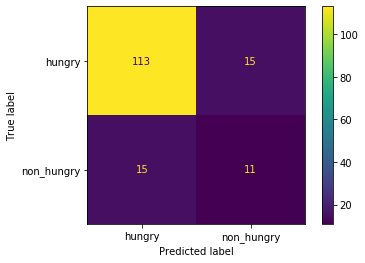

In [76]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()
plt.show

In [77]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,target_names=["Hungry","Non_hungry"]))

              precision    recall  f1-score   support

      Hungry       0.88      0.88      0.88       128
  Non_hungry       0.42      0.42      0.42        26

    accuracy                           0.81       154
   macro avg       0.65      0.65      0.65       154
weighted avg       0.81      0.81      0.81       154

